# Delta 2.0 for research methodology HT 2025
In this notebook we (i) analyze and preprocess data, (ii) performs predictions on positions, and (iii) train our own network for segmentation & analyze prediction outcomes. Steps for moving forward on this task are proposed in the markdown cell "Next steps!"

Please do read the README before running this notebook.

## Setting up our environment

In [1]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


The data is (for me) available in a google drive-folder "*data_12_04*" containing two subfolders "*images*" and "*masks*".

```
/content/data_12_04
├── images
└── masks
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip "/content/drive/MyDrive/forskningsmetodik/data_12_04 (1).zip" -d "/content/"
!cp "/content/drive/MyDrive/forskningsmetodik/cleaned.zip" -d "/content/"

Archive:  /content/drive/MyDrive/forskningsmetodik/data_12_04 (1).zip
replace /content/data_12_04/images/Pos101_img_000000000.tiff? [y]es, [n]o, [A]ll, [N]one, [r]ename: nA
replace /content/data_12_04/images/Pos101_img_000000001.tiff? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/data_12_04/images/Pos101_img_000000001.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000002.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000003.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000004.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000005.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000006.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000007.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000008.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000009.tiff  
  inflating: /content/data_12_04/images/Pos101_img_000000010.tiff  
  inflating: /content/data_12_04/images/Pos10

In [4]:
!pip install delta-microscopy[jax-gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.7/100.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.9/252.9 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23

In [106]:
import delta
import logging
from IPython.display import HTML
from base64 import b64encode
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from delta.config import Config
import os
from PIL import Image
import shutil
import os
import re
import glob
import pandas as pd
import random

DeLTA expects a naming-format "*pos1cha1fra000001.png*";

Handling this

In [5]:
folder = Path("/content/data_12_04/images")

for f in folder.glob("Pos*_img_*.tiff"):
    m = re.match(r"Pos(\d+)_img_(\d+)\.tiff", f.name)
    if not m:
        continue
    pos_num = int(m.group(1))
    frame_num = int(m.group(2))
    new_name = f"pos{pos_num}cha1fra{frame_num+1:06d}.png"
    f.rename(f.with_name(new_name))

In [6]:
sorted(glob.glob("/content/data_12_04/images/*.png"))[:20]

['/content/data_12_04/images/pos101cha1fra000001.png',
 '/content/data_12_04/images/pos101cha1fra000002.png',
 '/content/data_12_04/images/pos101cha1fra000003.png',
 '/content/data_12_04/images/pos101cha1fra000004.png',
 '/content/data_12_04/images/pos101cha1fra000005.png',
 '/content/data_12_04/images/pos101cha1fra000006.png',
 '/content/data_12_04/images/pos101cha1fra000007.png',
 '/content/data_12_04/images/pos101cha1fra000008.png',
 '/content/data_12_04/images/pos101cha1fra000009.png',
 '/content/data_12_04/images/pos101cha1fra000010.png',
 '/content/data_12_04/images/pos101cha1fra000011.png',
 '/content/data_12_04/images/pos101cha1fra000012.png',
 '/content/data_12_04/images/pos101cha1fra000013.png',
 '/content/data_12_04/images/pos101cha1fra000014.png',
 '/content/data_12_04/images/pos101cha1fra000015.png',
 '/content/data_12_04/images/pos101cha1fra000016.png',
 '/content/data_12_04/images/pos101cha1fra000017.png',
 '/content/data_12_04/images/pos101cha1fra000018.png',
 '/content

Ensuring data can be loaded into the xpreader properly

In [7]:
logger = logging.getLogger("delta")
logger.setLevel(logging.INFO)

config = delta.config.Config.default("2D")

movie_path = "/content/data_12_04/images/pos{p}cha{c}fra{t}.png"
reader = delta.utils.XPReader(movie_path)
pipeline = delta.pipeline.Pipeline(reader, config, resfolder="results")

100%|████████████████████████████████████████| 124M/124M [00:00<00:00, 201GB/s]
100%|████████████████████████████████████████| 124M/124M [00:00<00:00, 145GB/s]
INFO:delta.utils:Detecting image files...
INFO:delta.utils:Found images of size 499x782 and dtype uint16.
INFO:delta.utils:  10 positions (101-110)
INFO:delta.utils:  1 channels (1-1)
INFO:delta.utils:  121 time points (1-121)


## Processing data on the fully predefined pipeline (results, analysis)

Processing frames in Position 101

In [8]:
pipeline.process(positions=[101, 0], frames=range(1, 121))

INFO:delta.pipeline:Starting processing of position 101...
INFO:delta.pipeline:Starting pre-processing
INFO:delta.pipeline:1 RoI detected.
INFO:delta.pipeline:Starting segmentation (120 frames)
INFO:delta.pipeline:Segmentation - ROI 0
INFO:delta.pipeline:Starting tracking (120 frames)
INFO:delta.pipeline:Tracking - ROI 0
INFO:delta.pipeline:Starting growthrate computation (120 frames)
INFO:delta.pipeline:Saving to netCDF format: results/Position000101.nc
INFO:delta.pipeline:Saving - ROI 0
INFO:delta.pipeline:Saving results movie: results/Position000101.mp4
INFO:delta.pipeline:Clearing variables from memory


In [9]:
!ls results

Position000101.mp4  Position000101.nc


In [10]:
mp4 = Path("results/Position000101.mp4").open("rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4).decode()}"
HTML(f"<video width=600 controls><source src=\"{data_url}\" type=\"video/mp4\"></video>")

In [11]:
# Importing the netCDF file
pos = delta.pipeline.Position.load_netcdf(Path("results/Position000101.nc"))

In [12]:
print(pos)

Position #101
 ├─ 1 ROI(s)
 ├─ shape: (782, 499)
 └─ rotate: 0.0


In [13]:
print(pos.rois[0])

ROI #0
 ├─ box: CroppingBox(xtl=0, ytl=0, xbr=499, ybr=782)
 ├─ frames: 1 - 121
 ├─ scaling: (np.float64(1.0), np.float64(1.0))
 ├─ img_stack: (120, 782, 499)
 ├─ fluo_stack: (120, 0, 782, 499)
 ├─ seg_stack: (120, 782, 499)
 ├─ label_stack: (120, 782, 499)
 └─ lineage: lineage with 268 cell(s)


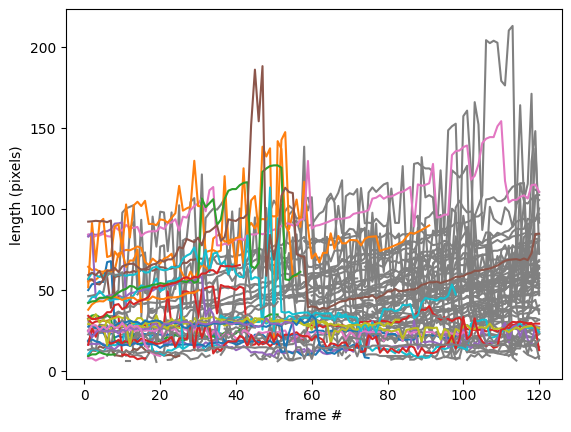

In [17]:
roi = pos.rois[0]
initial_cells = [
    cellid
    for cellid, cell in roi.lineage.cells.items()
    if cell.first_frame == roi.first_frame
]

for cellid, cell in roi.lineage.cells.items():
    if cellid not in initial_cells:
        lengths = [cell.features(frame).length for frame in cell.frames]
        plt.plot(cell.frames, lengths, color="gray")

for cellid in initial_cells:
    cell = roi.lineage.cells[cellid]
    lengths = [cell.features(frame).length for frame in cell.frames]
    plt.plot(cell.frames, lengths)

plt.xlabel("frame #")
plt.ylabel("length (pixels)")
plt.show()

In [18]:
roi = pos.rois[0]
seg = roi.seg_stack       # (frames, H, W)
labels = roi.label_stack
lin = roi.lineage

In [35]:
lin.compute_growthrates("area")

rows = []
for cell_id, cell in lin.cells.items():
    for frame in cell.frames:
        f = cell.features(frame)

        rows.append({
            "cell_id": cell_id,
            "frame": frame,
            "length": f.length,
            "area": f.area,
            "growthrate_length": f.growthrate_length,
            "growthrate_area": f.growthrate_area,
            "motherid": cell.motherid,
        })

df = pd.DataFrame(rows)
display(df[df["cell_id"] == 10])

cell_id  frame     length   area  growthrate_length  growthrate_area  \
667       10      1  10.242640   39.5           0.051016         0.086867   
668       10      2  13.071068   62.5           0.051016         0.086867   
669       10      3  13.071068   56.5           0.051016         0.086867   
670       10      4  11.656855   58.0           0.051016         0.086867   
671       10      5  11.656855   52.5           0.051016         0.046045   
..       ...    ...        ...    ...                ...              ...   
782       10    116  26.656855  160.0          -0.003797        -0.023818   
783       10    117  26.485281  151.0          -0.003797        -0.035238   
784       10    118  26.485281  154.0          -0.003797        -0.035238   
785       10    119  27.071068  149.0          -0.003797        -0.035238   
786       10    120  23.656855  132.5          -0.003797        -0.035238   

     motherid  
667       NaN  
668       NaN  
669       NaN  
670       NaN  
671       NaN  
..        ...  
782       NaN  
783       NaN  
784       NaN  
785       NaN  
786       NaN  

[120 rows x 7 columns]

In [27]:
cell = df[df.cell_id == 20].sort_values("frame")

<Axes: xlabel='frame'>

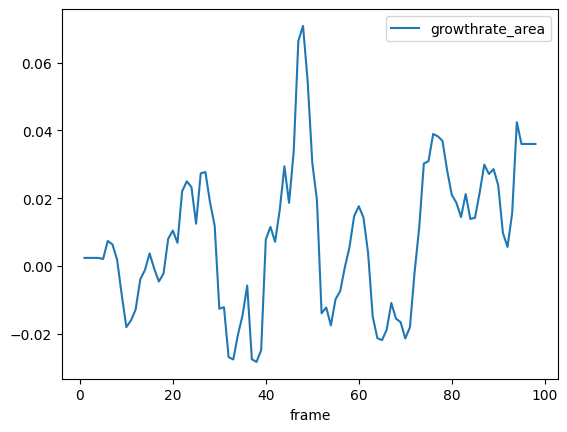

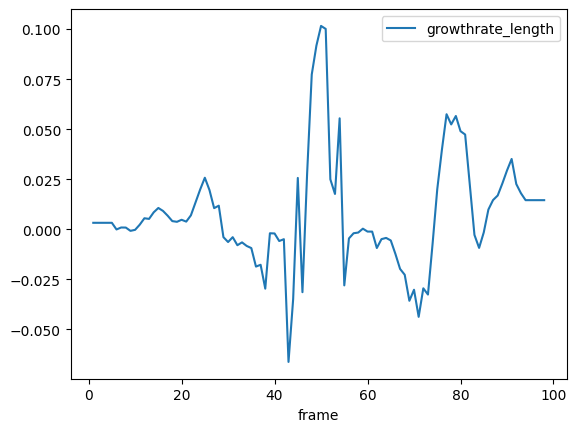

In [28]:
cell.plot(x="frame", y="growthrate_area")
cell.plot(x="frame", y="growthrate_length")

The growth appears very noisy.

**Idea:** *Could we collect growth (length, area) over time and average across all samples to early detect growth?*

In [37]:
display(df[df.frame==3])

cell_id  frame     length   area  growthrate_length  growthrate_area  \
2           1      3  23.656855  144.0           0.002791         0.011768   
100         2      3  56.242641  190.0           0.032613        -0.035774   
191         3      3  34.485283  216.5          -0.072278        -0.121455   
242         4      3  24.727922  136.0           0.012248        -0.022418   
362         5      3  83.899498  629.5           0.010803        -0.004983   
373         6      3  12.242640   42.0          -0.002789         0.134452   
398         7      3  83.384773  544.0           0.005984         0.016008   
518         8      3  12.656855   59.0           0.032041        -0.025878   
638         9      3  27.656855   80.0           0.017166         0.048684   
669        10      3  13.071068   56.5           0.051016         0.086867   
789        11      3  53.840622  336.0           0.031762         0.050798   
801        12      3  67.384773  563.0           0.033612         0.024619   
858        14      3  30.384777  158.0           0.011283         0.004707   
874        15      3  16.485281   66.5          -0.022128        -0.027559   
994        16      3  53.698486  340.0          -0.005726         0.002552   
1025       17      3  24.828426   68.0           0.001126         0.001379   
1126       18      3  27.656855   71.0           0.003538         0.009698   
1246       19      3  34.899494  125.0           0.001243        -0.009674   
1366       20      3  58.941124  374.0           0.003250         0.002379   
1464       21      3  18.071068   92.5          -0.012383        -0.010753   
1539       22      3  62.597980  378.5           0.007470         0.004810   
1554       23      3  10.071068   27.5           0.005994         0.062732   
1562       24      3  20.899494   96.0          -0.022987         0.002418   
1682       25      3  44.384777  277.0          -0.001175         0.000465   
1717       26      3  92.597977  603.5           0.001035        -0.005539   
1726       27      3   6.242640   30.0           0.005548        -0.014617   
1731       28      3  46.970562  322.5           0.041039         0.033574   
1782       29      3  26.656855  133.0          -0.012096        -0.014903   
1865       30      3  45.698486  278.5          -0.001675         0.004734   
1891       31      3  26.242641  189.0           0.006209         0.000557   
1959       32      3  42.556351  314.5           0.020016         0.032008   
1989       33      3  43.041630  296.0           0.015254         0.019647   
2046       34      3  31.899494  218.5           0.030730         0.019036   
2087       35      3  23.656855  166.5           0.004632         0.013470   
2145       36      3  59.041630  417.5           0.006046        -0.014268   
2265       37      3  28.071068   75.5           0.004704         0.026789   
2285       38      3  13.656855   47.5          -0.009545        -0.005020   
2403       39      3  32.627419  208.0          -0.000289        -0.019909   
2415       40      3  14.242640   27.0                NaN              NaN   

      motherid  
2          NaN  
100        NaN  
191        NaN  
242        NaN  
362        NaN  
373        NaN  
398        NaN  
518        NaN  
638        NaN  
669        NaN  
789        NaN  
801        NaN  
858        NaN  
874        NaN  
994        NaN  
1025       NaN  
1126       NaN  
1246       NaN  
1366       NaN  
1464       NaN  
1539       NaN  
1554       NaN  
1562       NaN  
1682       NaN  
1717       NaN  
1726       NaN  
1731       NaN  
1782       NaN  
1865       NaN  
1891       NaN  
1959       NaN  
1989       NaN  
2046       NaN  
2087       NaN  
2145       NaN  
2265       NaN  
2285       NaN  
2403      25.0  
2415       NaN

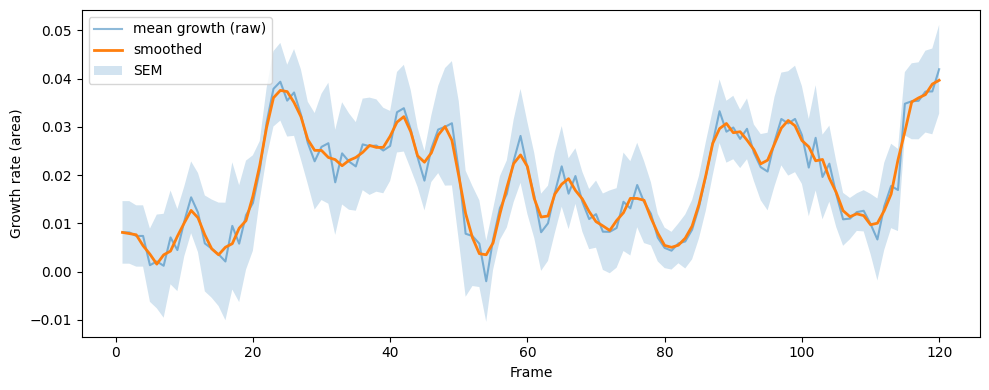

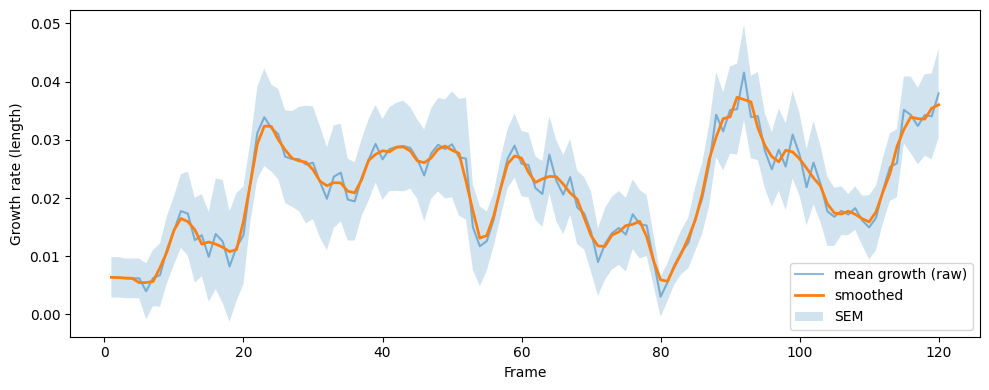

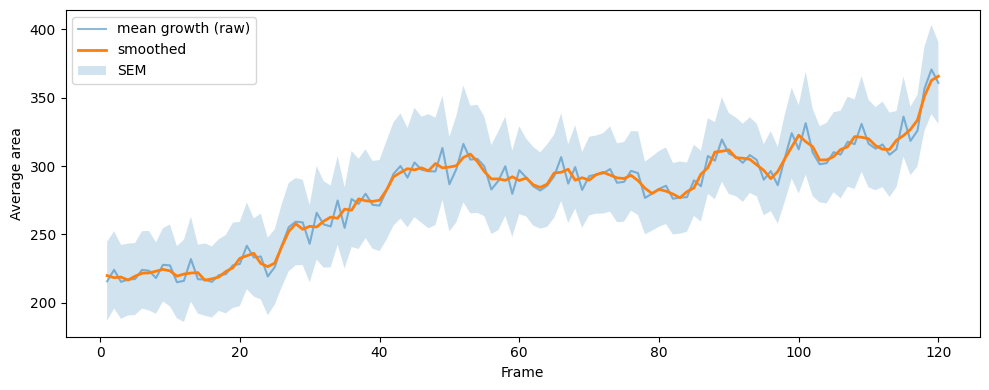

In [53]:
# define some helper functions

def aggregate_gr(df):
  ## aggregating growthrates (area)
  agg_area = df.groupby("frame")["growthrate_area"].agg(
      mean="mean",
      median="median",
      std="std",
      count="count"
  )
  agg_area["sem"] = agg_area["std"] / agg_area["count"].pow(0.5)

  ## smoothing
  agg_area["smooth"] = agg_area["mean"].rolling(window=3, center=True, min_periods=1).mean()
  #display(agg_area.head())

  ## aggregating growthrates (length)
  agg_length = df.groupby("frame")["growthrate_length"].agg(
      mean="mean",
      median="median",
      std="std",
      count="count"
  )
  agg_length["sem"] = agg_length["std"] / agg_length["count"].pow(0.5)

  ## smoothing with rolling window of size 3
  agg_length["smooth"] = agg_length["mean"].rolling(window=3, center=True, min_periods=1).mean()
  #display(agg_length.head())

  return agg_area, agg_length

def average_area(df):
  agg_area = df.groupby("frame")["area"].agg(
      mean="mean",
      median="median",
      std="std",
      count="count"
  )
  agg_area["sem"] = agg_area["std"] / agg_area["count"].pow(0.5)
  ## smoothing with rolling window of size 3
  agg_area["smooth"] = agg_area["mean"].rolling(window=3, center=True, min_periods=1).mean()
  return agg_area

## visualization
agg_area, agg_length = aggregate_gr(df)
avr_area = average_area(df)

def visualize_aggregated_features(df, x_label, y_label):
  plt.figure(figsize=(10,4))
  plt.plot(df.index, df["mean"], alpha=0.5, label="mean growth (raw)")
  plt.plot(df.index, df["smooth"], linewidth=2, label="smoothed")
  plt.fill_between(df.index, df["mean"]-df["sem"], df["mean"]+df["sem"],
                  alpha=0.2, label="SEM")

  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.tight_layout()
  plt.show()

visualize_aggregated_features(agg_area, "Frame", "Growth rate (area)")
visualize_aggregated_features(agg_length, "Frame", "Growth rate (length)")
visualize_aggregated_features(avr_area, "Frame", "Average area")


With these helper functions we can extract rolling features

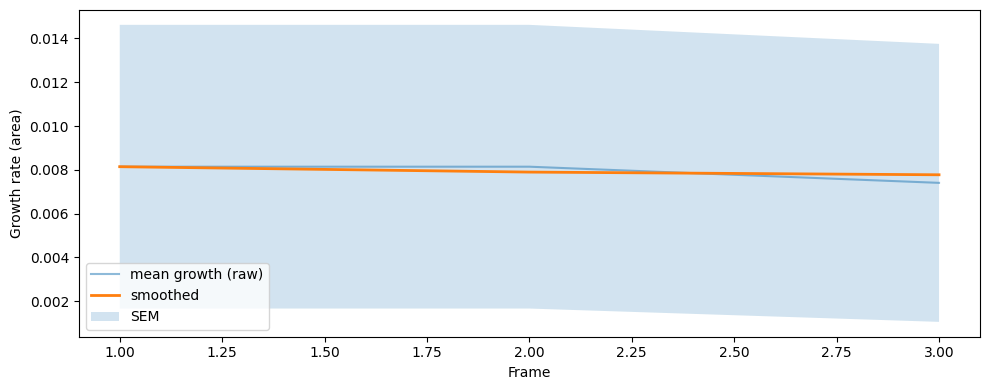

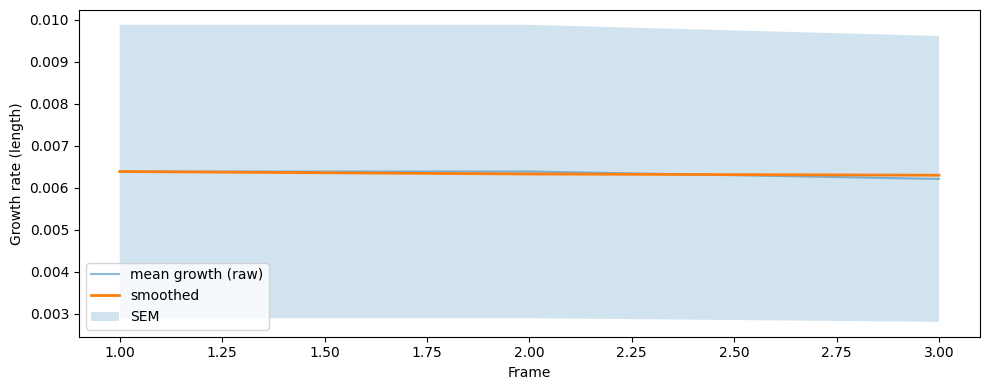

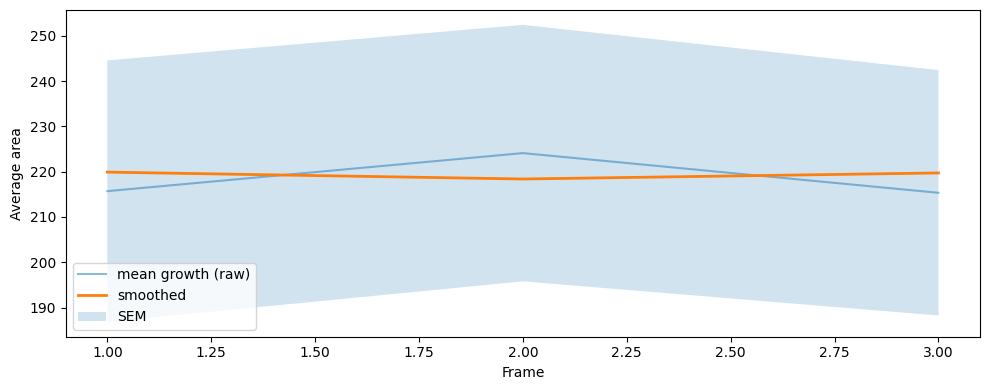

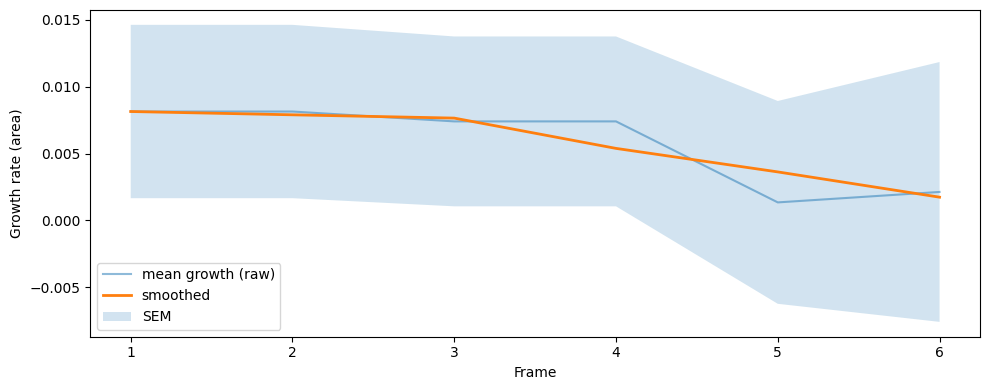

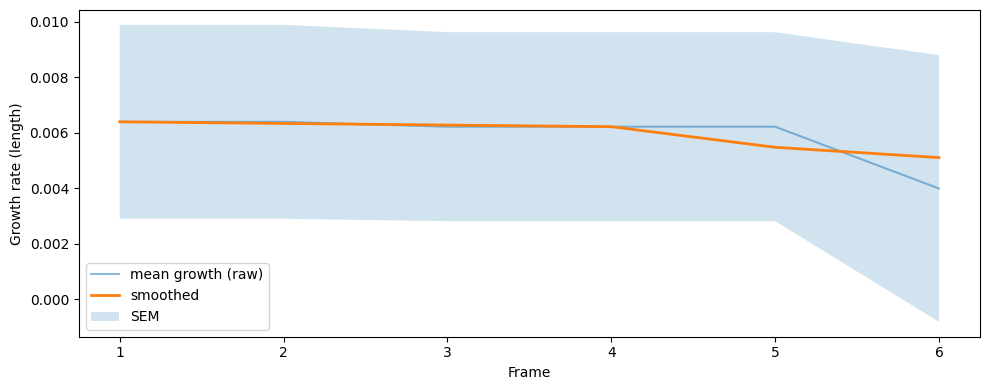

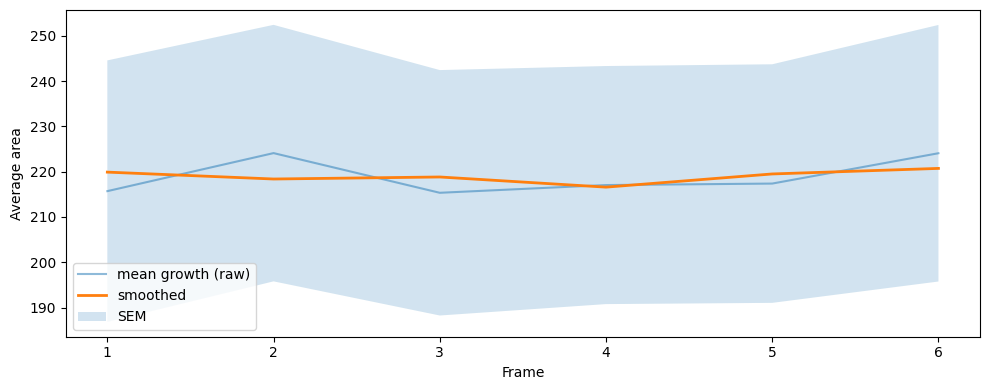

In [57]:
subset_3frames = df[df.frame.isin([1,2,3])]
agg_area, agg_length = aggregate_gr(subset_3frames)
avr_area = average_area(subset_3frames)
visualize_aggregated_features(agg_area, "Frame", "Growth rate (area)")
visualize_aggregated_features(agg_length, "Frame", "Growth rate (length)")
visualize_aggregated_features(avr_area, "Frame", "Average area")

subset_6frames = df[df.frame.isin([1,2,3,4,5,6])]
agg_area, agg_length = aggregate_gr(subset_6frames)
avr_area = average_area(subset_6frames)
visualize_aggregated_features(agg_area, "Frame", "Growth rate (area)")
visualize_aggregated_features(agg_length, "Frame", "Growth rate (length)")
visualize_aggregated_features(avr_area, "Frame", "Average area")

The growthrates seems to fluctuate but is generally positive. In order to assess this method we would have to compare resistant/non-resistant;

*train a simple classifier?*

## Analyzing segmentation output; Preparing data for training

Upon analyzing the masks generated by Omnipose it is evident that multiple cells in many cases are labeled as one. Preprocessing of this output (generating the DeLTA-weights) will result in incorrect skeletons. To handle this, the masks have been preprocessed in *mask_processing.ipynb*. While cells are sometimes cut up in this processed variation of the masks, the weights might handle this problem, giving us cleaner segmentation.

First i trained a segmentation model on the given (omnipose) masks, the cells are saved here for analysis.

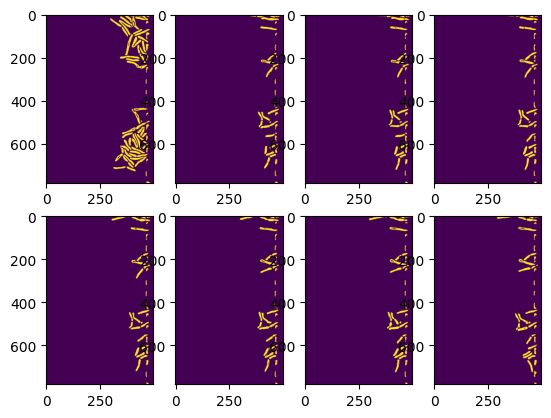

In [58]:
f, a = plt.subplots(2,4)
a = a.ravel()
for i in range(0, 8):
  a[i].imshow(np.array(pos.rois[0].get_seg(i*2)))

Borders are detected as cells, clusters of cells are detected as one.. Lets try to do some finetuning.

DeLTA assumes the folder "*training_dataset*" containing "*img*" and "*seg*" for training.

In [60]:
base = Path("training_dataset")
img_folder = base / "img"
seg_folder = base / "seg"

img_folder.mkdir(parents=True, exist_ok=True)
seg_folder.mkdir(parents=True, exist_ok=True)

In [61]:
img_src = Path("/content/data_12_04/images")
mask_src = Path("/content/data_12_04/masks")

base = Path("training_dataset")
img_dest = base / "img"
mask_dest = base / "seg"
img_files = sorted(img_src.glob("*.png"))
mask_files = sorted(mask_src.glob("*.tif"))

if len(img_files) != len(mask_files):
    raise ValueError(f"Number of images ({len(img_files)}) and masks ({len(mask_files)}) do not match!")

for i, (img_file, mask_file) in enumerate(zip(img_files, mask_files), 1):
    img_new = img_dest / f"sample-{i:04d}{img_file.suffix}"
    shutil.copy(img_file, img_new)
    mask_new = mask_dest / f"sample-{i:04d}.png"
    mask_img = Image.open(mask_file)

    mask_img = mask_img.convert("L")
    mask_img.save(mask_new)


In [62]:
# The size of the masks and the observed images differ!! (?????)
image_sizes = []
mask_sizes = []
for f in os.listdir("/content/training_dataset/img/"):
  img = Image.open("/content/training_dataset/img/"+f)
  image_sizes.append(img.size)
  if img.size != (499, 782):
    print(f)

for f in os.listdir("/content/training_dataset/seg/"):
  img = Image.open("/content/training_dataset/seg/"+f)
  mask_sizes.append(img.size)
  if img.size != (499, 782):
    print(f)


sample-0871.png
sample-1153.png
sample-0288.png
sample-0646.png
sample-0399.png
sample-0488.png
sample-0749.png
sample-0672.png
sample-0487.png
sample-0453.png
sample-1084.png
sample-0906.png
sample-0750.png
sample-0962.png
sample-0441.png
sample-1192.png
sample-0863.png
sample-0705.png
sample-0078.png
sample-0179.png
sample-0915.png
sample-0304.png
sample-0884.png
sample-0636.png
sample-0247.png
sample-0496.png
sample-0218.png
sample-1144.png
sample-0263.png
sample-0149.png
sample-0210.png
sample-1064.png
sample-0548.png
sample-0993.png
sample-0622.png
sample-0893.png
sample-0983.png
sample-0774.png
sample-1087.png
sample-0501.png
sample-0605.png
sample-0660.png
sample-0924.png
sample-0108.png
sample-0720.png
sample-1076.png
sample-0140.png
sample-1139.png
sample-0120.png
sample-0485.png
sample-0611.png
sample-0285.png
sample-0668.png
sample-0486.png
sample-0326.png
sample-1164.png
sample-0208.png
sample-0944.png
sample-1156.png
sample-1106.png
sample-0542.png
sample-0846.png
sample-0

In [63]:
folder_path = "/content/training_dataset/seg"
target_height, target_width = 782, 499

for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".tif"):
        mask_path = os.path.join(folder_path, filename)
        mask = np.array(Image.open(mask_path))
        cropped_mask = mask[:target_height, :target_width]
        # binarize the mask for unet
        cropped_mask_img = Image.fromarray(cropped_mask > 0)

        # Optional: save back (overwrite)
        cropped_mask_img.save(mask_path)
        #print(filename, "size:", cropped_mask_img.size)

#plt.imshow(cropped_mask > 0)

In [64]:
!tree /content/training_dataset

/content/training_dataset
├── img
│   ├── sample-0001.png
│   ├── sample-0002.png
│   ├── sample-0003.png
│   ├── sample-0004.png
│   ├── sample-0005.png
│   ├── sample-0006.png
│   ├── sample-0007.png
│   ├── sample-0008.png
│   ├── sample-0009.png
│   ├── sample-0010.png
│   ├── sample-0011.png
│   ├── sample-0012.png
│   ├── sample-0013.png
│   ├── sample-0014.png
│   ├── sample-0015.png
│   ├── sample-0016.png
│   ├── sample-0017.png
│   ├── sample-0018.png
│   ├── sample-0019.png
│   ├── sample-0020.png
│   ├── sample-0021.png
│   ├── sample-0022.png
│   ├── sample-0023.png
│   ├── sample-0024.png
│   ├── sample-0025.png
│   ├── sample-0026.png
│   ├── sample-0027.png
│   ├── sample-0028.png
│   ├── sample-0029.png
│   ├── sample-0030.png
│   ├── sample-0031.png
│   ├── sample-0032.png
│   ├── sample-0033.png
│   ├── sample-0034.png
│   ├── sample-0035.png
│   ├── sample-0036.png
│   ├── sample-0037.png
│   ├── sample-0038.png
│   ├── sample-0039.png
│   ├── sample-0040.png
│   ├─

Remove the weights generated by the training script (if it has been run); If not, ignore

In [ ]:
!rm -rf /content/training_dataset/wei/

## Training Our own model on our data

In [ ]:
!delta train --config 2D --model seg --input /content/training_dataset/ --output my_model.keras

2025-12-07 21:52:58.056676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765144378.076498   20622 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765144378.082416   20622 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765144378.097840   20622 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765144378.097867   20622 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765144378.097871   20622 computation_placer.cc:177] computation placer alr

In [ ]:
config = Config.default("2D")
config.models['seg'].model_path = Path(
    "my_model.keras"
)

movie_path = "/content/data_12_04/images/pos{p}cha{c}fra{t}.png"
reader = delta.utils.XPReader(movie_path)
pipeline = delta.pipeline.Pipeline(reader, config, resfolder="results")
pipeline.process(positions=[101, 0], frames=range(1, 21))

INFO:delta.utils:Detecting image files...
INFO:delta.utils:Found images of size 499x782 and dtype uint16.
INFO:delta.utils:  10 positions (101-110)
INFO:delta.utils:  1 channels (1-1)
INFO:delta.utils:  121 time points (1-121)
INFO:delta.pipeline:Starting processing of position 101...
INFO:delta.pipeline:Starting pre-processing
INFO:delta.pipeline:1 RoI detected.
INFO:delta.pipeline:Starting segmentation (20 frames)
INFO:delta.pipeline:Segmentation - ROI 0
INFO:delta.pipeline:Starting tracking (20 frames)
INFO:delta.pipeline:Tracking - ROI 0
INFO:delta.pipeline:Starting growthrate computation (20 frames)
INFO:delta.pipeline:Saving to netCDF format: results/Position000101.nc
INFO:delta.pipeline:Saving - ROI 0
INFO:delta.pipeline:Saving results movie: results/Position000101.mp4
INFO:delta.pipeline:Clearing variables from memory


In [ ]:

mp4 = Path("results/Position000101.mp4").open("rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4).decode()}"
HTML(f"<video width=600 controls><source src=\"{data_url}\" type=\"video/mp4\"></video>")

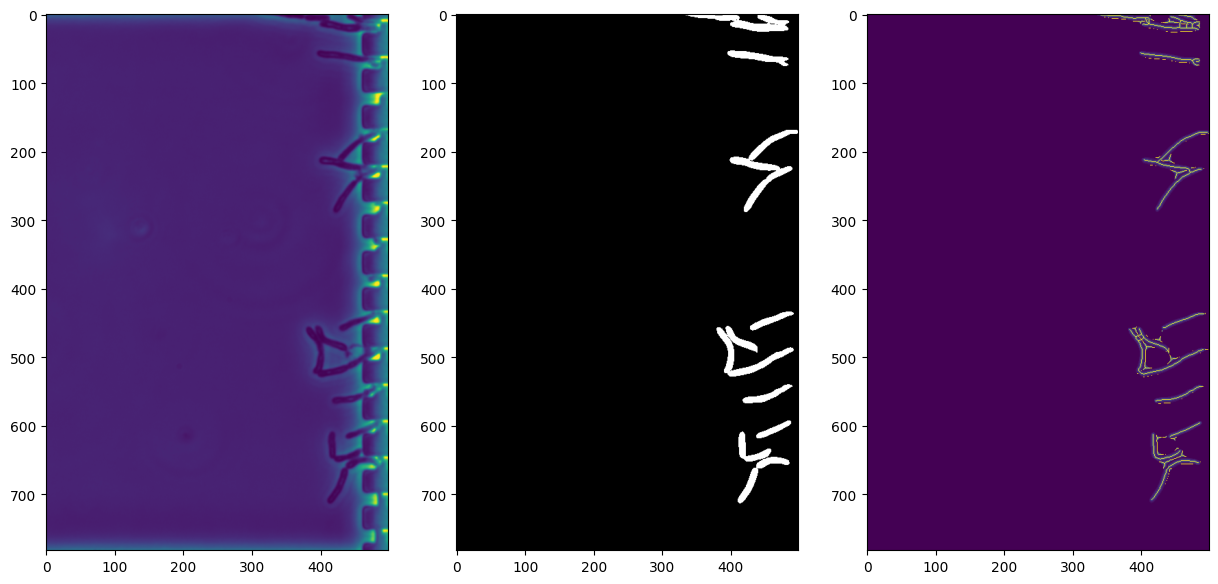

In [ ]:
image = Image.open("/content/training_dataset/img/sample-0001.png")
mask = Image.open("/content/training_dataset/seg/sample-0001.png")
wei = Image.open("/content/training_dataset/wei/sample-0001.png")

f, a = plt.subplots(1,3)
f.set_figheight(15)
f.set_figwidth(15)

a[0].imshow(image)
a[1].imshow(mask)
a[2].imshow(wei)

## Splitting masks and retraining

In order for the weightmap and the segmentation to accurately work with the tracking algorithm we must ensure that individual cellmasks are separated.

Here we are importing the updated masks and training the model.

In [65]:
!rm -rf *.tif

In [93]:
!unzip "/content/cleaned.zip" -d "/content/cleaned"

Archive:  /content/cleaned.zip
  inflating: /content/cleaned/Pos105_MASK_img_000000074.tif  
replace /content/cleaned/Pos103_MASK_img_000000029.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/cleaned/Pos103_MASK_img_000000029.tif  
  inflating: /content/cleaned/Pos107_MASK_img_000000086.tif  
  inflating: /content/cleaned/Pos106_MASK_img_000000074.tif  
  inflating: /content/cleaned/Pos104_MASK_img_000000044.tif  
  inflating: /content/cleaned/Pos105_MASK_img_000000109.tif  
  inflating: /content/cleaned/Pos108_MASK_img_000000038.tif  
  inflating: /content/cleaned/Pos108_MASK_img_000000086.tif  
  inflating: /content/cleaned/Pos110_MASK_img_000000062.tif  
  inflating: /content/cleaned/Pos110_MASK_img_000000098.tif  
  inflating: /content/cleaned/Pos107_MASK_img_000000089.tif  
  inflating: /content/cleaned/Pos104_MASK_img_000000105.tif  
  inflating: /content/cleaned/Pos109_MASK_img_000000092.tif  
  inflating: /content/cleaned/Pos105_MASK_img_000000037.tif  
  inf

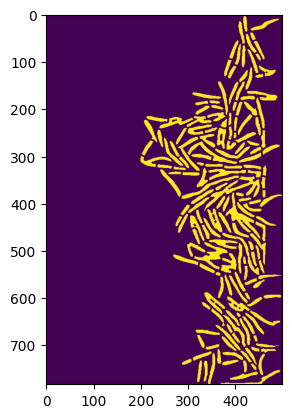

In [94]:
clean_masks = glob.glob("/content/cleaned/*.tif")

for path in clean_masks:
    filename = os.path.basename(path)
    mask = Image.open(path)
    mask = np.array(mask)
    binary = (mask > 0).astype(np.uint8) * 255
    binary_img = Image.fromarray(binary)
    binary_img.save(path)


plt.imshow(binary_img)

Take 4 Positions and store for testing

In [88]:
!rm -rf training_dataset

In [95]:
mask_folder = Path("/content/cleaned")
image_folder = Path("/content/data_12_04/images")
test_p = Path("test_set")
test_p.mkdir(parents=True, exist_ok=True)

# arbitrary positions
positions_to_move = ["pos102", "pos105", "pos106", "pos109"]

for mask_file in mask_folder.glob("*.tif"):
    if any(pos in mask_file.name.lower() for pos in positions_to_move):
        shutil.move(str(mask_file), test_p / mask_file.name)

for img_file in image_folder.glob("*.png"):
    if any(pos in img_file.name.lower() for pos in positions_to_move):
        shutil.move(str(img_file), test_p / img_file.name)


In [103]:
mask_folder = Path("/content/test_set")
test_gt_path = Path("test_gt_seg")
test_gt_path.mkdir(parents=True, exist_ok=True)

positions_to_move = ["pos102", "pos105", "pos106", "pos109"]

for mask_file in mask_folder.glob("*.tif"):
    if any(pos in mask_file.name.lower() for pos in positions_to_move):
        shutil.move(str(mask_file), test_gt_path / mask_file.name)

Create our training dataset!

In [97]:
img_src = Path("/content/data_12_04/images")
mask_src = Path("/content/cleaned")


base = Path("training_dataset")
img_dest = base / "img"
mask_dest = base / "seg"
mask_dest.mkdir(parents=True, exist_ok=True)
img_dest.mkdir(parents=True, exist_ok=True)

img_files = sorted(img_src.glob("*.png"))
mask_files = sorted(mask_src.glob("*.tif"))

if len(img_files) != len(mask_files):
    raise ValueError(f"Number of images ({len(img_files)}) and masks ({len(mask_files)}) do not match!")

for i, (img_file, mask_file) in enumerate(zip(img_files, mask_files), 1):
    img_new = img_dest / f"sample-{i:04d}{img_file.suffix}"
    shutil.copy(img_file, img_new)
    mask_new = mask_dest / f"sample-{i:04d}.png"
    mask_img = Image.open(mask_file)

    mask_img = mask_img.convert("L")
    mask_img.save(mask_new)

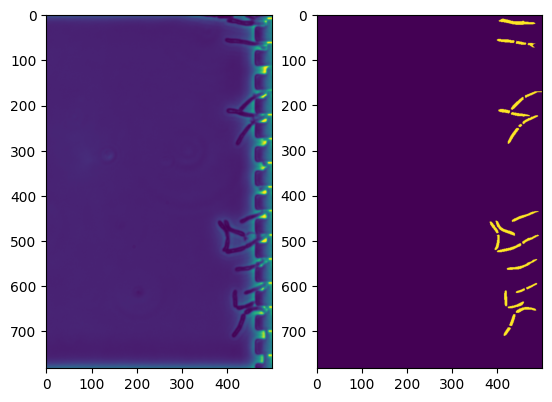

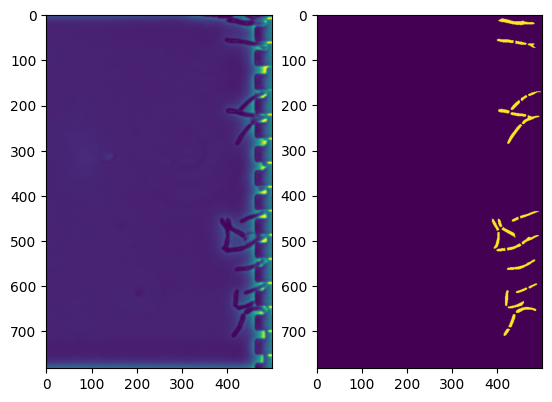

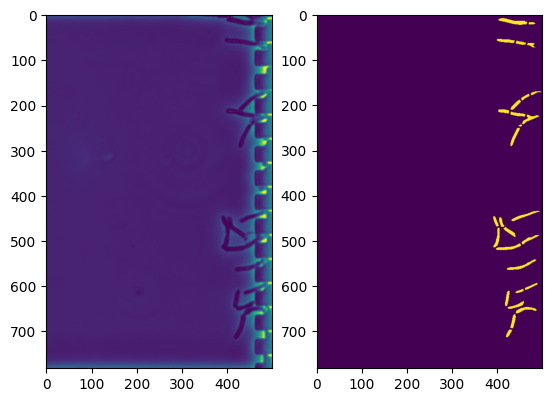

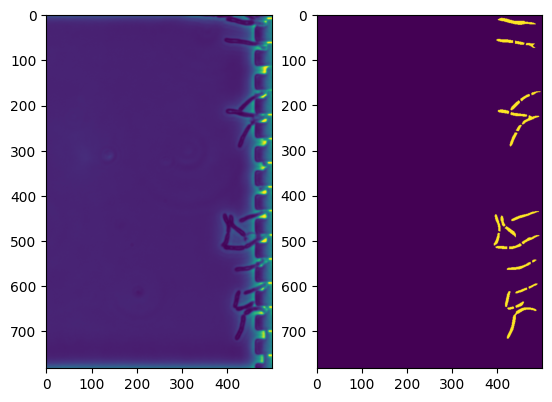

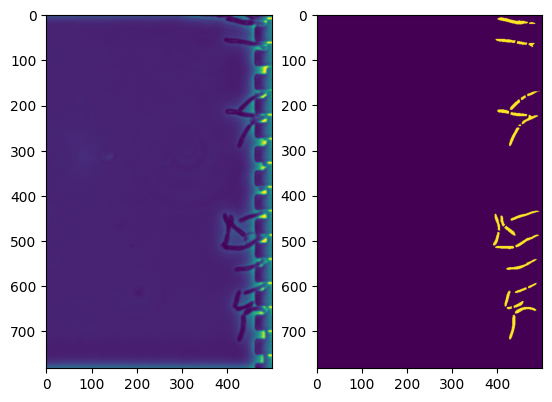

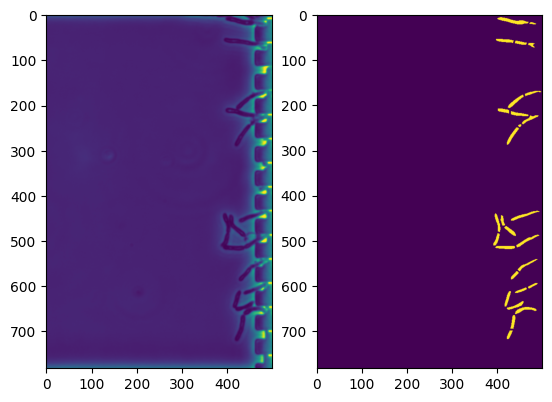

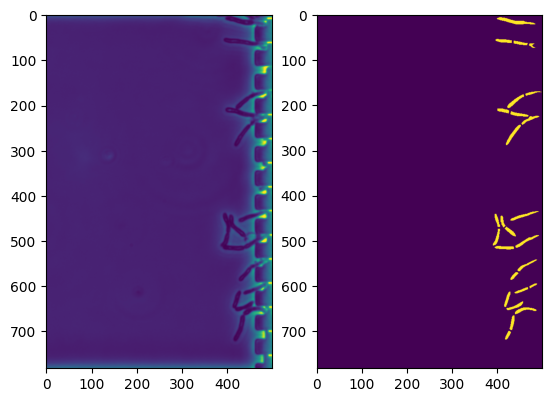

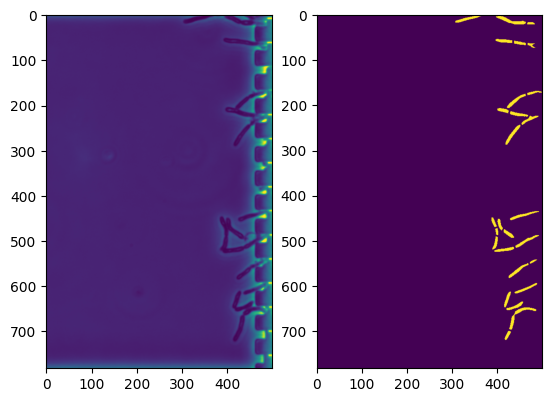

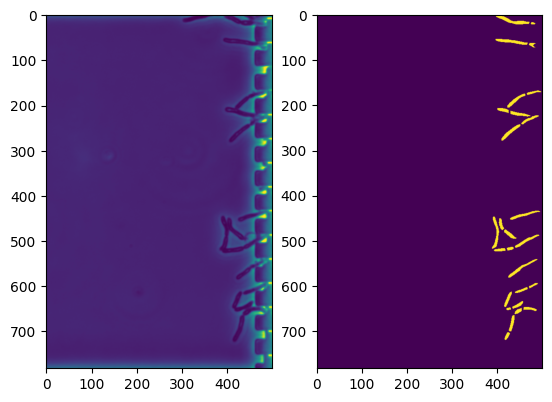

In [98]:
img_src = Path("/content/training_dataset/img")
mask_src = Path("/content/training_dataset/seg")

img_files = sorted(img_src.glob("*.png"))
mask_files = sorted(mask_src.glob("*.png"))

for i, (img_file, mask_file) in enumerate(zip(img_files, mask_files), 1):
  if (i < 10):
    f, a = plt.subplots(1,2)
    a[0].imshow(Image.open(img_file))
    a[1].imshow(Image.open(mask_file))
  else:
    continue

Resize mask to fit image

In [99]:
folder_path = "/content/training_dataset/seg"
target_height, target_width = 782, 499

for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".tif"):
        mask_path = os.path.join(folder_path, filename)
        mask = np.array(Image.open(mask_path))
        cropped_mask = mask[:target_height, :target_width]
        cropped_mask_img = Image.fromarray(cropped_mask > 0)
        cropped_mask_img.save(mask_path)

Train!

In [100]:
# if old version of the weights exists
!rm -rf /content/training_dataset/wei/

In [101]:
!delta train --config 2D --model seg --input /content/training_dataset/ --output my_model_clean_masks.keras

2025-12-11 15:21:00.550900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765466460.583928   40596 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765466460.594874   40596 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765466460.621287   40596 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765466460.621332   40596 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765466460.621342   40596 computation_placer.cc:177] computation placer alr

Visualizing the weights used to train the model

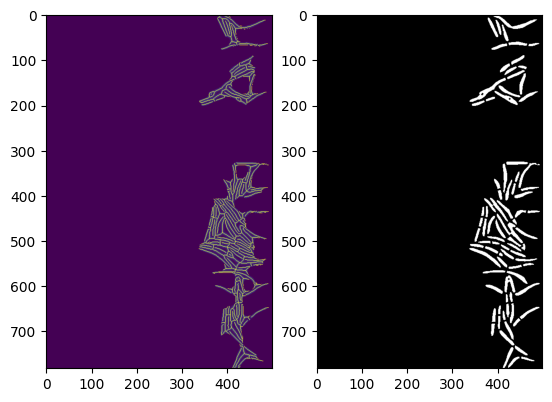

In [112]:
weights = glob.glob("/content/training_dataset/wei/*.png")
maks = glob.glob("/content/training_dataset/seg/*.png")

random_sample = random.randint(0, len(weights))

f, a = plt.subplots(1,2)
a[0].imshow(Image.open(weights[random_sample]))
a[1].imshow(Image.open(maks[random_sample]))

## Processing Position 102 with our newly trained model

In [113]:
config = Config.default("2D")
config.models['seg'].model_path = Path(
    "my_model_clean_masks.keras"
)

movie_path = "/content/test_set/pos{p}cha{c}fra{t}.png"
reader = delta.utils.XPReader(movie_path)
pipeline = delta.pipeline.Pipeline(reader, config, resfolder="results")
pipeline.process(positions=[102, 0], frames=range(1, 121))

INFO:delta.utils:Detecting image files...
INFO:delta.utils:Found images of size 499x782 and dtype uint16.
INFO:delta.utils:  4 positions (102-109)
INFO:delta.utils:  1 channels (1-1)
INFO:delta.utils:  121 time points (1-121)
INFO:delta.pipeline:Starting processing of position 102...
INFO:delta.pipeline:Starting pre-processing
INFO:delta.pipeline:1 RoI detected.
INFO:delta.pipeline:Starting segmentation (120 frames)
INFO:delta.pipeline:Segmentation - ROI 0
INFO:delta.pipeline:Starting tracking (120 frames)
INFO:delta.pipeline:Tracking - ROI 0
INFO:delta.pipeline:Starting growthrate computation (120 frames)
INFO:delta.pipeline:Saving to netCDF format: results/Position000102.nc
INFO:delta.pipeline:Saving - ROI 0
INFO:delta.pipeline:Saving results movie: results/Position000102.mp4
INFO:delta.pipeline:Clearing variables from memory


In [114]:
mp4 = Path("results/Position000102.mp4").open("rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4).decode()}"
HTML(f"<video width=600 controls><source src=\"{data_url}\" type=\"video/mp4\"></video>")

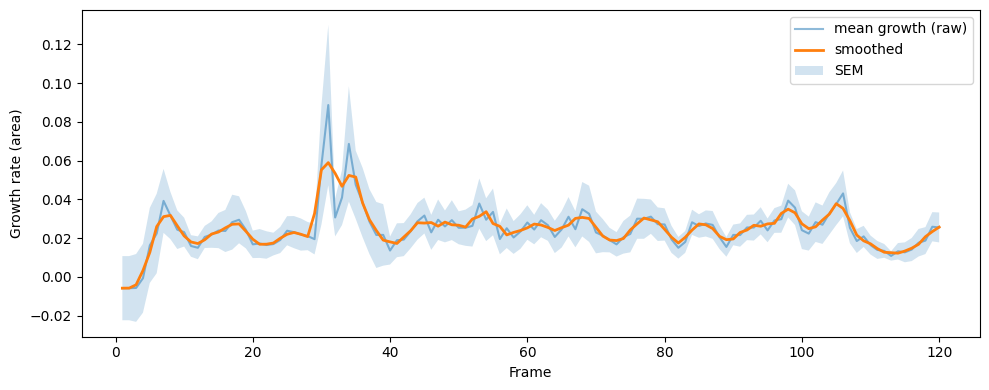

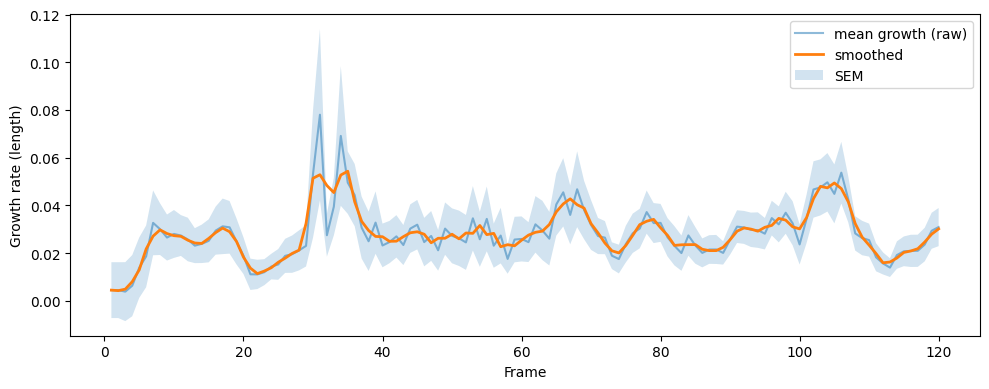

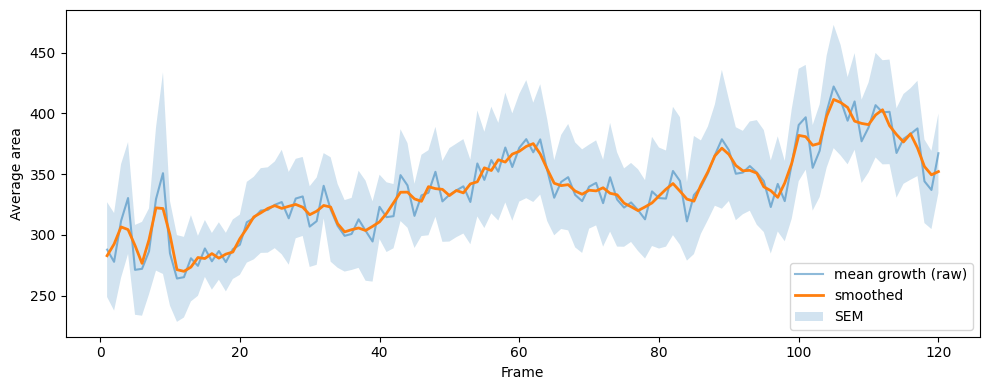

In [115]:
# Importing the netCDF file
pos = delta.pipeline.Position.load_netcdf(Path("results/Position000102.nc"))
roi = pos.rois[0]
lin = roi.lineage
lin.compute_growthrates("area")

rows = []
for cell_id, cell in lin.cells.items():
    for frame in cell.frames:
        f = cell.features(frame)

        rows.append({
            "cell_id": cell_id,
            "frame": frame,
            "length": f.length,
            "area": f.area,
            "growthrate_length": f.growthrate_length,
            "growthrate_area": f.growthrate_area,
            "motherid": cell.motherid,
        })

df = pd.DataFrame(rows)

agg_area, agg_length = aggregate_gr(df)
avr_area = average_area(df)

visualize_aggregated_features(agg_area, "Frame", "Growth rate (area)")
visualize_aggregated_features(agg_length, "Frame", "Growth rate (length)")
visualize_aggregated_features(avr_area, "Frame", "Average area")

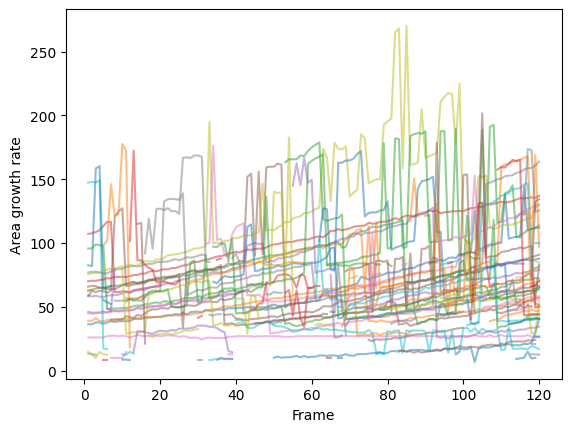

In [117]:
for cell_id in df['cell_id'].unique():
    cell_df = df[df['cell_id'] == cell_id]
    plt.plot(cell_df['frame'], cell_df['length'], alpha=0.5)
plt.xlabel("Frame")
plt.ylabel("Area growth rate")
plt.show()

## Next steps!

From our analysis so far, both area- and length-based growth rates indicate that the cells are indeed growing, which is consistent with the observed increase in cell area over time. Although the measurements are somewhat noisy, they align with growth visible by eye. To enable early detection, a small neural network (e.g, LSTM or 1D CNN) could be trained to classify the sample. Using short smoothing windows allows the model to leverage data from the earliest frames, and combining the raw area with the noisy growth-rate features should provide sufficient information for accurate classification even at these early time points.

Next steps:
- *Implement and train pipeline for early detection*
- *Evaluate over available data*